1.Эльф-домовик Добби любит вязать носки для своего друга Гарри Поттера. Размер получающихся у Добби носков — нормально распределенная случайная величина. Гарри заметил, что носки получаются короче 10 дюймов с вероятностью 10%, а длиннее 12 дюймов — с вероятностью 5%. Найдите стандартное отклонение распределения размера носков в дюймах.

В ответе укажите число. При необходимости округлите его по правилам математики до трёх знаков после запятой. В качестве разделителя используйте точку.

Решение: так как размер носков — нормально распределенная случайная величина то можем вычислить ppf для 10% и для 95%

In [3]:
import scipy

left_border = scipy.stats.norm.ppf(0.10)
right_border = scipy.stats.norm.ppf(0.95)

print(left_border, right_border)

-1.2815515655446004 1.6448536269514722


Теперь зная реальные и стандартные пороговые значения можно подставить в уравнение уравнение связи квантиля распределения с квантилем стандартного нормального распределения. (x - μ) / σ = z 

(10 - μ) / σ = -1.2815515655446004

(12 - μ) / σ = 1.6448536269514722

вычту из 2 уравнения 1

12 - 10 / σ = 2.9264051924960726


In [4]:
sigma = 2 / 2.9264051924960726
sigma

0.6834323575998384

2.На процедуре проверки зрения посетителю с вероятностью 50% показывают слово ШШММ, с вероятностью 20% — слово МЫШШ, а с вероятностью 30% — слово ЫЫЫЫ. У Леонида не очень хорошее зрение, поэтому каждую из трех букв (М, Ш и Ы) он независимо от остальных определяет верно с вероятностью 60%, а с вероятностями в 20% может распознать её как любую из оставшихся. С какой вероятностью Леониду показали слово МЫШШ, если он увидел слово ШЫЫШ?

В ответе укажите число. При необходимости округлите его по правилам математики до трёх знаков после запятой. В качестве разделителя используйте точку.


По теореме Байеса:

P(МЫШШ ∣ ШЫЫШ)= 0.2 ⋅ 0.0144 / 0.5 ⋅ 0.0048 + 0.2 ⋅ 0.0144 + 0.3 ⋅ 0.0144 = 0.3

3. В файле data.csv по ссылке хранятся измерения некоторого показателя в подряд идущие моменты времени. Ваша задача — предсказать значения показателя в следующие 336 моментов времени после последнего момента из data.csv.

В качестве ответа нужно послать файл из 336 строк, в каждой строке которого находится ТОЛЬКО очередное предсказание.

Задание засчитывается, если RMSE будет меньше 50.


Пробовал решать rnn и transformer но зашли ряды Фурье

In [8]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
import math
from itertools import product

data = pd.read_csv("/kaggle/input/yandex-camp-spbgu-data/data.csv")
series = data['value'].values

train_size = 1000
train, val = series[:train_size], series[train_size:train_size+345]

def create_features(series, n_lags, periods, fourier_order):
    X, y = [], []
    for i in range(n_lags, len(series)):
        row = list(series[i-n_lags:i])
        for season_period in periods:
            for k in range(1, fourier_order+1):
                row.append(np.sin(2 * np.pi * k * i / season_period))
                row.append(np.cos(2 * np.pi * k * i / season_period))
        X.append(row)
        y.append(series[i])
    return np.array(X), np.array(y)

n_lags_list = [100, 150, 200]
periods_list = [
    [24],
    [48],
    [24, 48],
    [24, 48, 168] 
]
fourier_orders = [3, 5, 7]
alphas = [0.1, 0.5, 1.0]

best_rmse = float("inf")
best_params = None
best_forecast = None

for n_lags, periods, fourier_order, alpha in product(n_lags_list, periods_list, fourier_orders, alphas):
    X_train, y_train = create_features(train, n_lags, periods, fourier_order)

    model = Ridge(alpha=alpha)
    model.fit(X_train, y_train)
    
    history = list(train[-n_lags:])
    forecast = []
    for t in range(len(val)):
        i = train_size + t
        x_input = list(history[-n_lags:])
        for season_period in periods:
            for k in range(1, fourier_order+1):
                x_input.append(np.sin(2 * np.pi * k * i / season_period))
                x_input.append(np.cos(2 * np.pi * k * i / season_period))
        yhat = model.predict([x_input])[0]
        forecast.append(yhat)
        history.append(yhat)
    
    rmse = math.sqrt(mean_squared_error(val, forecast))
    
    if rmse < best_rmse:
        best_rmse = rmse
        best_params = (n_lags, periods, fourier_order, alpha)
        best_forecast = forecast
    
    print(f"n_lags={n_lags}, periods={periods}, fourier_order={fourier_order}, alpha={alpha} -> RMSE={rmse:.4f}")

print("Best RMSE:", best_rmse)
print("Best params:", best_params)

pd.Series(np.round(best_forecast).astype(int)).to_csv("predictions.txt", index=False, header=False)


n_lags=100, periods=[24], fourier_order=3, alpha=0.1 -> RMSE=68.6873
n_lags=100, periods=[24], fourier_order=3, alpha=0.5 -> RMSE=68.7421
n_lags=100, periods=[24], fourier_order=3, alpha=1.0 -> RMSE=68.8084
n_lags=100, periods=[24], fourier_order=5, alpha=0.1 -> RMSE=68.7810
n_lags=100, periods=[24], fourier_order=5, alpha=0.5 -> RMSE=68.8370
n_lags=100, periods=[24], fourier_order=5, alpha=1.0 -> RMSE=68.9046
n_lags=100, periods=[24], fourier_order=7, alpha=0.1 -> RMSE=68.8806
n_lags=100, periods=[24], fourier_order=7, alpha=0.5 -> RMSE=68.9355
n_lags=100, periods=[24], fourier_order=7, alpha=1.0 -> RMSE=69.0018
n_lags=100, periods=[48], fourier_order=3, alpha=0.1 -> RMSE=70.4033
n_lags=100, periods=[48], fourier_order=3, alpha=0.5 -> RMSE=70.4442
n_lags=100, periods=[48], fourier_order=3, alpha=1.0 -> RMSE=70.4936
n_lags=100, periods=[48], fourier_order=5, alpha=0.1 -> RMSE=69.4458
n_lags=100, periods=[48], fourier_order=5, alpha=0.5 -> RMSE=69.4982
n_lags=100, periods=[48], fourier_

Находим собственные векторы для B и переводим матрицу A в координаты собственных векторов B т.к в них B - диагональная после по норме Фробениуса находим разницу

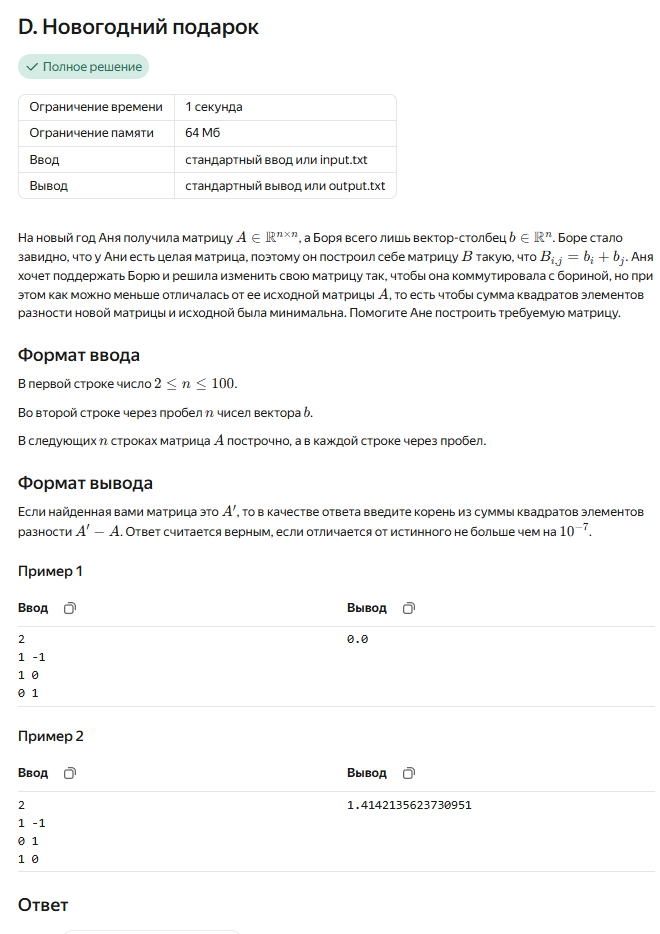

In [1]:
import numpy as np

n = int(input())
b = np.array(list(map(float, input().split())))
A = np.zeros((n, n))
for i in range(n):
    A[i] = list(map(float, input().split()))


ones_vector = np.ones(n)
B = np.outer(b, ones_vector) + np.outer(ones_vector, b)

eigenvalues, P = np.linalg.eigh(B)

A_tilde = P.T @ A @ P

epsilon = 1e-9

frobenius_norm_squared = 0.0
for i in range(n):
    for j in range(n):
        if abs(eigenvalues[i] - eigenvalues[j]) > epsilon:
            frobenius_norm_squared += A_tilde[i, j] ** 2

result = np.sqrt(frobenius_norm_squared)
print(f"{result:.16f}")


 2
 1 -1
 0 1
  1 0


1.4142135623730951


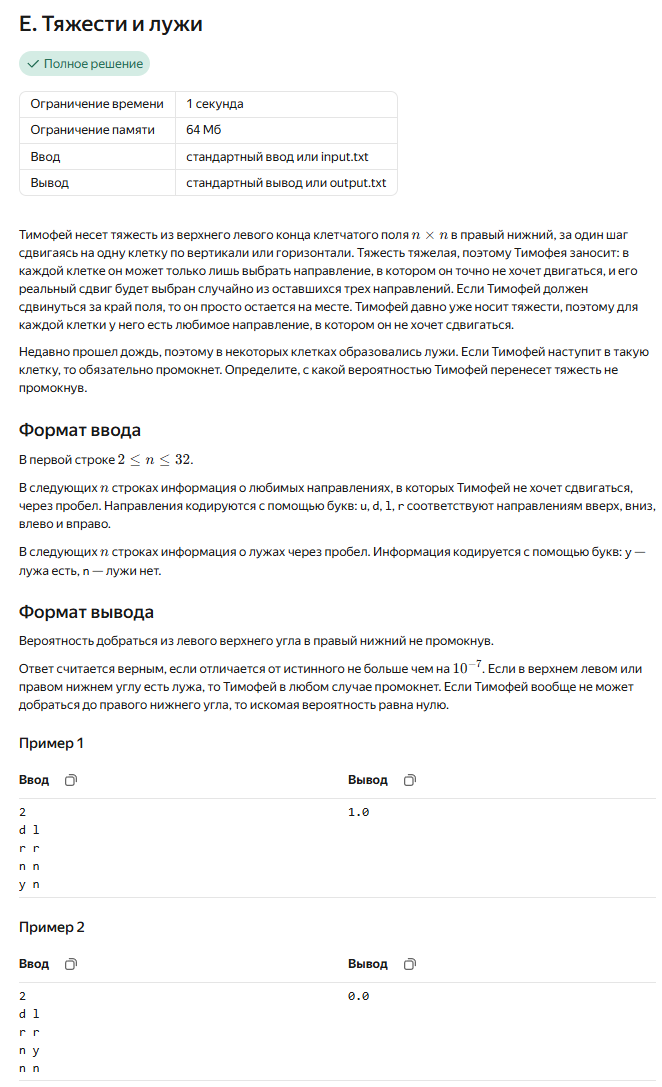

Система линейных уравнений

In [2]:
import numpy as np

n = int(input())

forbidden = [input().split() for _ in range(n)]
puddles = [input().split() for _ in range(n)]

if puddles[0][0] == 'y' or puddles[n-1][n-1] == 'y':
    print(0.0)
    exit()

dirs = {'u': (-1,0), 'd': (1,0), 'l': (0,-1), 'r': (0,1)}

N = n*n
A = np.zeros((N, N))
b = np.zeros(N)

for i in range(n):
    for j in range(n):
        idx = i*n + j
        if puddles[i][j] == 'y':
            A[idx, idx] = 1
            b[idx] = 0
            continue
        if i==n-1 and j==n-1:
            A[idx, idx] = 1
            b[idx] = 1
            continue
        A[idx, idx] = 1
        forbidden_dir = forbidden[i][j][0]
        for d, (di,dj) in dirs.items():
            if d == forbidden_dir:
                continue
            ni, nj = i+di, j+dj
            if 0 <= ni < n and 0 <= nj < n:
                A[idx, ni*n + nj] -= 1/3
            else:
                A[idx, idx] -= 1/3 

x = np.linalg.solve(A, b)
print(x[0])

 2
 d l 
 r r
 n y
 n n


0.0
